In [17]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

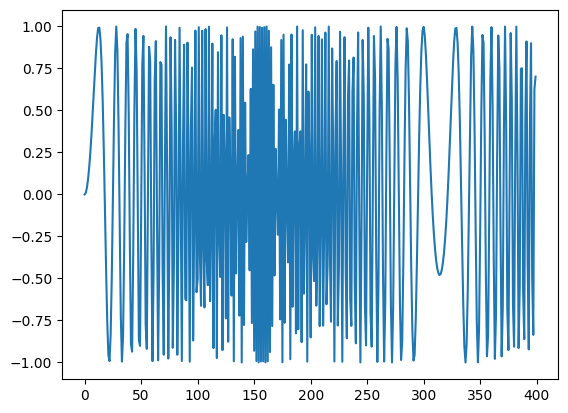

In [18]:
#Make the original data
N = 400
series = np.sin((0.1*np.arange(N))**2)

#plot it
plt.plot(series)
plt.show()

In [19]:
#Build dataset
T = 10
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print(f"Y Shape: {Y.shape}, X Shape: {X.shape}")

Y Shape: (390, 1), X Shape: (390, 10, 1)


In [20]:
#Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [21]:
class SimpleRNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(SimpleRNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.GRU(
        input_size = self.D,
        hidden_size = self.M,
        num_layers = self.L,
        batch_first = True
    )

    self.fc = nn.Linear(self.M, self.K)

  def forward(self, x):
    h0 = torch.zeros(self.L, x.size(0), self.M).to(device)
    out, _ = self.rnn(x, h0)
    out = self.fc(out[:, -1, :])
    return out

In [22]:
#Try SimpleRNN model
model = SimpleRNN(n_inputs = 1, n_hidden=10, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): GRU(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [23]:
#Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [24]:
#Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [25]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [26]:
#Training
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses[it] = loss.item()

    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it+1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train_loss: {loss.item():.4f}, Test_loss: {test_loss.item():.4f}')
  return train_losses, test_losses


In [27]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test)

Epoch 5/200, Train_loss: 0.5199, Test_loss: 0.5863
Epoch 10/200, Train_loss: 0.4743, Test_loss: 0.5548
Epoch 15/200, Train_loss: 0.2572, Test_loss: 0.2544
Epoch 20/200, Train_loss: 0.1126, Test_loss: 0.1812
Epoch 25/200, Train_loss: 0.0470, Test_loss: 0.0921
Epoch 30/200, Train_loss: 0.0372, Test_loss: 0.0687
Epoch 35/200, Train_loss: 0.0206, Test_loss: 0.0634
Epoch 40/200, Train_loss: 0.0161, Test_loss: 0.0570
Epoch 45/200, Train_loss: 0.0125, Test_loss: 0.0532
Epoch 50/200, Train_loss: 0.0094, Test_loss: 0.0536
Epoch 55/200, Train_loss: 0.0071, Test_loss: 0.0480
Epoch 60/200, Train_loss: 0.0053, Test_loss: 0.0463
Epoch 65/200, Train_loss: 0.0043, Test_loss: 0.0471
Epoch 70/200, Train_loss: 0.0038, Test_loss: 0.0473
Epoch 75/200, Train_loss: 0.0032, Test_loss: 0.0475
Epoch 80/200, Train_loss: 0.0028, Test_loss: 0.0470
Epoch 85/200, Train_loss: 0.0025, Test_loss: 0.0472
Epoch 90/200, Train_loss: 0.0022, Test_loss: 0.0471
Epoch 95/200, Train_loss: 0.0021, Test_loss: 0.0486
Epoch 100/200

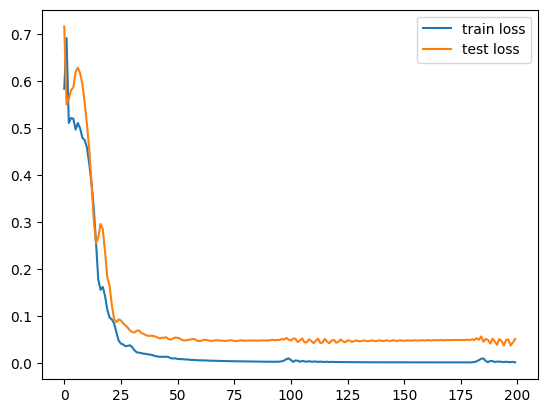

In [28]:
#Plot th train loss and test loss per iteration
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.legend()
plt.show()

In [29]:
#Wrong forecast using targets
validation_target = Y[-N//2:]
validation_predictions = []

i = 0
while len(validation_predictions) < len(validation_target):
  input_ = X_test[i].view(1, T, 1)
  p = model(input_)[0, 0].item()
  i +=1
  validation_predictions.append(p)

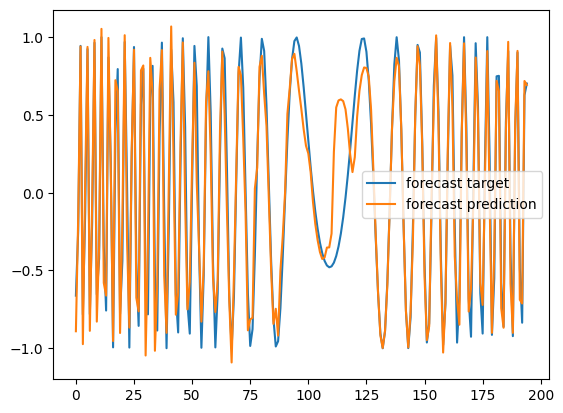

In [30]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [31]:
#Forecast future values
validation_target = Y[-N//2: ]
validation_predictions = []

last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)

  validation_predictions.append(p[0, 0].item())
  #Make the new input
  last_x = torch.cat((last_x[1:], p[0]))

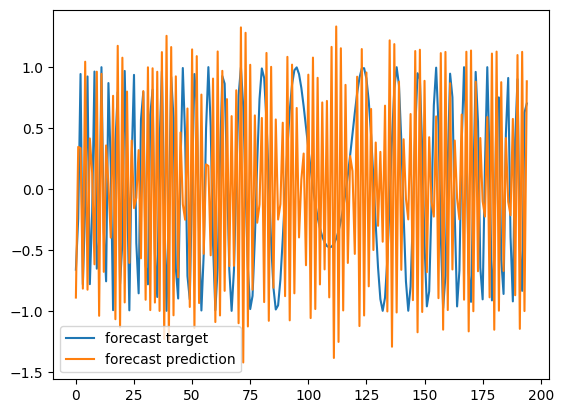

In [32]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()